In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [2]:
train_data = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960.csv')
new_train_data = train_data.copy()
train_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
#train_data.info()

In [4]:
train_labels = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
train_labels.set_index('id', inplace=True)
train_labels.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [5]:
train_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [6]:
# train_data = train_data.merge(train_labels, on='id', how='inner')
# train_data['status_group'] = train_data['status_group'].astype('category')

## Хочу нанести на карту точки!

In [7]:
import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
import seaborn as sns

In [8]:
train_data[['longitude', 'latitude']] = train_data[['longitude', 'latitude']].astype(float)

In [9]:
latitude = train_data.loc[train_data['longitude'] > 20, 'latitude'].values
longitude = train_data.loc[train_data['longitude'] > 20, 'longitude'].values

In [10]:
# здесь будет карта с точками
# поправь название 
 # поправь цвета точек
    # поправь размер карты

In [11]:
# m = Basemap(width=10000000, height=6000000, projection='lcc', resolution=None,
#             lat_0=latitude.mean(), lon_0=longitude.mean(), lat_1=latitude.min(), lon_1=longitude.min(),
#            lat_2=latitude.max(), lon_2=longitude.max())
# x, y = m(longitude, latitude)
# m.scatter(x, y, .1, marker='o',color=train_data['status_group'].map(
#     {'functional': 'blue', 'functional needs repair': 'red', 'non functional': 'white'}))
# m.bluemarble()
# plt.title('Точки))')
# plt.show()

# Визуализируем матрицу корреляции
### Есть предположение, что некоторые признаки сильно коррелируют друг с другом, а значит, от них можно избавиться.
Например, `extraction_type`, `extraction_type_group` и `extraction_type_class`

Для этого подготовим исходные данные  
Сделаем следующие действия:
* с помощью колонок `date_recorded` и `construction_year` вычислим возраст точки и поделим на три категории;
* заменим категориальные строковые признаки на целочисленные (не забыв сохранять словари таких замен, чтобы корректно проделать то же самое на тестовом датасете);
* заменить некторые небольшие значения колонок `funder` и `installer`, чтобы как-то поработать с этой информацией

В колонке `construction_year` почти 35% пропусков, что не дает корретно посчитать возраст точки.  
Попробую заменить нули медианным значением всех остальных годов.

In [12]:
median_train_constr_year = int(new_train_data.loc[new_train_data['construction_year'] > 0, 
                                                  'construction_year'].median())
median_train_constr_year

2000

In [13]:
def year_to_categorical(year):
    if year >= median_train_constr_year:
        return 1
    elif (year < median_train_constr_year) & (year > 0):
        return 2
    else:
        return 0

Это значение равно 2000. Тогда, половину сделаем старше, половину младше 2000))  
В любом случае, можно попробовать с этим признакоми без него (просто оставить нули??).

Избавимся от NaN и соберем группу `other` для колонок `funder` и `installer`  
Словари и среднее нам пригодятся при подготовке тестовых данных

In [14]:
new_train_data['funder'] = new_train_data['funder'].fillna('unknown')
new_train_data['installer'] = new_train_data['installer'].fillna('unknown')

funder_dict = dict(zip(new_train_data['funder'].value_counts(normalize=True).index.values, 
                       new_train_data['funder'].value_counts(normalize=True).values))
installer_dict = dict(zip(new_train_data['installer'].value_counts(normalize=True).index.values, 
                       new_train_data['installer'].value_counts(normalize=True).values))

funder_mean = new_train_data['funder'].value_counts(normalize=True).values.mean()
installer_mean = new_train_data['installer'].value_counts(normalize=True).values.mean()

new_train_data['funder'] = new_train_data['funder'].apply(
    lambda funder: funder if funder_dict[funder] > funder_mean else 'Other')
new_train_data['installer'] = new_train_data['installer'].apply(
    lambda installer: installer if installer_dict[installer] > installer_mean else 'Other')

funder_train_dict = dict(zip(new_train_data['funder'].value_counts().index.values, 
                         np.arange(1, new_train_data['funder'].value_counts().index.shape[0] + 1)))
installer_train_dict = dict(zip(new_train_data['installer'].value_counts().index.values, 
                         np.arange(1, new_train_data['installer'].value_counts().index.shape[0] + 1)))

In [15]:
def prepare_data(data):
    
    # Словари исходного тренировочного датасета.
    region_train_dict = dict(zip(train_data['region'].value_counts().index.values, 
                         np.arange(1, train_data['region'].value_counts().index.shape[0] + 1)))
    lga_train_dict = dict(zip(train_data['lga'].value_counts().index.values, 
                         np.arange(1, train_data['lga'].value_counts().index.shape[0] + 1)))
    basin_train_dict = dict(zip(train_data['basin'].value_counts().index.values, 
                         np.arange(1, train_data['basin'].value_counts().index.shape[0] + 1)))
    public_meeting_train_dict = dict(zip(train_data['public_meeting'].fillna('Unknown').value_counts().index.values, 
                         np.arange(1, train_data['public_meeting'].fillna('Unknown').value_counts().index.shape[0] + 1)))
    scheme_management_train_dict = dict(zip(train_data['scheme_management'].fillna('Unknown').value_counts().index.values, 
                         np.arange(1, train_data['scheme_management'].fillna('Unknown').value_counts().index.shape[0] + 1)))
    permit_train_dict = dict(zip(train_data['permit'].fillna('Unknown').value_counts().index.values, 
                         np.arange(1, train_data['permit'].fillna('Unknown').value_counts().index.shape[0] + 1)))
    extraction_type_train_dict = dict(zip(train_data['extraction_type'].value_counts().index.values, 
                         np.arange(1, train_data['extraction_type'].value_counts().index.shape[0] + 1)))
    extraction_type_group_train_dict = dict(zip(train_data['extraction_type_group'].value_counts().index.values, 
                         np.arange(1, train_data['extraction_type_group'].value_counts().index.shape[0] + 1)))
    extraction_type_class_train_dict = dict(zip(train_data['extraction_type_class'].value_counts().index.values, 
                         np.arange(1, train_data['extraction_type_class'].value_counts().index.shape[0] + 1)))
    management_train_dict = dict(zip(train_data['management'].value_counts().index.values, 
                         np.arange(1, train_data['management'].value_counts().index.shape[0] + 1)))
    management_group_train_dict = dict(zip(train_data['management_group'].value_counts().index.values, 
                         np.arange(1, train_data['management_group'].value_counts().index.shape[0] + 1)))
    payment_train_dict = dict(zip(train_data['payment'].value_counts().index.values, 
                         np.arange(1, train_data['payment'].value_counts().index.shape[0] + 1)))
    payment_type_train_dict = dict(zip(train_data['payment_type'].value_counts().index.values, 
                         np.arange(1, train_data['payment_type'].value_counts().index.shape[0] + 1)))
    water_quality_train_dict = dict(zip(train_data['water_quality'].value_counts().index.values, 
                         np.arange(1, train_data['water_quality'].value_counts().index.shape[0] + 1)))
    quality_group_train_dict = dict(zip(train_data['quality_group'].value_counts().index.values, 
                         np.arange(1, train_data['quality_group'].value_counts().index.shape[0] + 1)))
    quantity_train_dict = dict(zip(train_data['quantity'].value_counts().index.values, 
                         np.arange(1, train_data['quantity'].value_counts().index.shape[0] + 1)))
    quantity_group_train_dict = dict(zip(train_data['quantity_group'].value_counts().index.values, 
                         np.arange(1, train_data['quantity_group'].value_counts().index.shape[0] + 1)))
    source_train_dict = dict(zip(train_data['source'].value_counts().index.values, 
                         np.arange(1, train_data['source'].value_counts().index.shape[0] + 1)))
    source_type_train_dict = dict(zip(train_data['source_type'].value_counts().index.values, 
                         np.arange(1, train_data['source_type'].value_counts().index.shape[0] + 1)))
    source_class_train_dict = dict(zip(train_data['source_class'].value_counts().index.values, 
                         np.arange(1, train_data['source_class'].value_counts().index.shape[0] + 1)))
    waterpoint_type_train_dict = dict(zip(train_data['waterpoint_type'].value_counts().index.values, 
                         np.arange(1, train_data['waterpoint_type'].value_counts().index.shape[0] + 1)))
    waterpoint_type_group_train_dict = dict(zip(train_data['waterpoint_type_group'].value_counts().index.values, 
                         np.arange(1, train_data['waterpoint_type_group'].value_counts().index.shape[0] + 1)))

    # Удалим (ненужные?) признаки.
    data.drop(columns=['date_recorded', 'longitude', 'latitude', 'wpt_name', 'num_private', 'subvillage', 
                       'ward', 'recorded_by', 'scheme_name'], axis=1, inplace=True)
    
    # Категориальные признаки заменим числовыми значениями, полученным из тренировочного датасета.
    data['region'] = data['region'].map(region_train_dict)
    data['lga'] = data['lga'].map(lga_train_dict)
    data['basin'] = data['basin'].map(basin_train_dict)
    data['public_meeting'] = data['public_meeting'].fillna('Unknown').map(public_meeting_train_dict)
    data['scheme_management'] = data['scheme_management'].fillna('Unknown').map(scheme_management_train_dict)
    data['permit'] = data['permit'].fillna('Unknown').map(permit_train_dict)
    data['extraction_type'] = data['extraction_type'].map(extraction_type_train_dict)
    data['extraction_type_group'] = data['extraction_type_group'].map(extraction_type_group_train_dict)
    data['extraction_type_class'] = data['extraction_type_class'].map(extraction_type_class_train_dict)
    data['management'] = data['management'].map(management_train_dict)
    data['management_group'] = data['management_group'].map(management_group_train_dict)
    data['payment'] = data['payment'].map(payment_train_dict)
    data['payment_type'] = data['payment_type'].map(payment_type_train_dict)
    data['water_quality'] = data['water_quality'].map(water_quality_train_dict)
    data['quality_group'] = data['quality_group'].map(quality_group_train_dict)
    data['quantity'] = data['quantity'].map(quantity_train_dict)
    data['quantity_group'] = data['quantity_group'].map(quantity_group_train_dict)
    data['source'] = data['source'].map(source_train_dict)
    data['source_type'] = data['source_type'].map(source_type_train_dict)
    data['source_class'] = data['source_class'].map(source_class_train_dict)
    data['waterpoint_type'] = data['waterpoint_type'].map(waterpoint_type_train_dict)
    data['waterpoint_type_group'] = data['waterpoint_type_group'].map(waterpoint_type_group_train_dict)
    data['funder'] = data['funder'].map(funder_train_dict)
    data['installer'] = data['installer'].map(installer_train_dict)
    
    # Вычислим возрастную категорию каждой точки.
   # median_train_construction_year = int(train_data.loc[train_data['construction_year'] > 0, 
    #                                                'construction_year'].median())
    #data['date_recorded'] = data['date_recorded'].apply(lambda date: int(date[:4]))
    data['age'] = data['construction_year'].apply(year_to_categorical)
    data.drop('construction_year', axis=1, inplace=True)
  #  data['construction_year'] = data['construction_year'].apply(
       # lambda year: median_train_construction_year if year == 0 else int(year))
    #data['age'] = [age_category(age) for age in (abs(data['date_recorded'] - data['construction_year']))]
   # data.drop(columns=['date_recorded', 'construction_year'], axis=1, inplace=True)

    data.set_index('id', inplace=True) 
    return data

In [16]:
new_train_data = prepare_data(new_train_data)
new_train_data.head()

,amount_tsh,funder,gps_height,installer,basin,region,region_code,district_code,lga,population,public_meeting,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,37,1390,93,7,1,11,5,38,109,1,1,2,1,1,1,1,1,6,6,1,1,1,1,1,1,1,1,1,2
8776,0.0,139,1399,166,1,15,20,2,23,280,3,10,1,1,1,1,2,1,1,1,1,1,2,2,5,5,2,1,1,1
34310,25.0,2,686,18,2,19,21,4,82,250,1,1,1,1,1,1,1,1,2,2,1,1,1,1,8,6,2,4,1,1
67743,0.0,10,263,36,8,18,90,63,110,58,1,1,1,4,4,4,1,1,1,1,1,1,3,3,3,3,1,4,1,2
19728,0.0,2,0,63,1,7,18,1,20,0,1,3,1,1,1,1,8,4,1,1,1,1,4,4,5,5,2,1,1,0


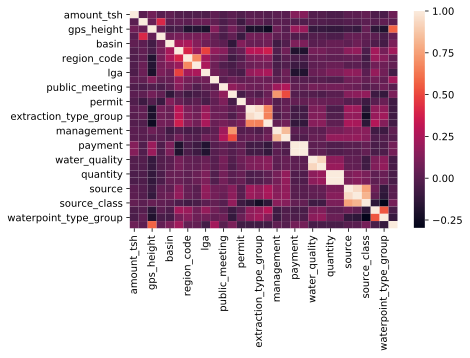

In [17]:
sns.heatmap(new_train_data.corr());

### Видим ожидаемо высокую корреляцию между некоторыми признаками:
* `region` и `lga`
* `region_code` и `district_code`
* `extraction_type`, `extraction_type_group` и `extraction_type_class`
* `management`, `management_group` и `scheme_management`
* `payment` и `payment_type`
* `water_quality` и `quality_group`
* `quantity` и `quantity_group`
* `source`, `source_type` и `source_class`
* `waterpont_type` и `waterpoint_type_group`  

Удалим коррелирующие признаки, исходя из их размерности  
Оставлю тех, которых больше, т.к. читал следующее про случайный лес, который я планирую использовать:
> если данные содержат группы коррелированных признаков, имеющих схожую значимость для меток, то предпочтение отдается небольшим группам перед большими  
 
И из пар (`region_code`, `district_code`) и (`region`, `lga`) оставлю признаки, наименее коррелирующие друг с другом и  относящиеся одовременно и к региону и к району. Кажется, такие признаки `region` и `district_code`

In [18]:
new_train_data['extraction_type'].value_counts().shape[0],\
new_train_data['extraction_type_group'].value_counts().shape[0],\
new_train_data['extraction_type_class'].value_counts().shape[0]

(18, 13, 7)

In [19]:
new_train_data['management'].value_counts().shape[0],\
new_train_data['management_group'].value_counts().shape[0],\
new_train_data['scheme_management'].value_counts().shape[0]

(12, 5, 13)

In [20]:
new_train_data['payment'].value_counts().shape[0],\
new_train_data['payment_type'].value_counts().shape[0]

(7, 7)

In [21]:
new_train_data['water_quality'].value_counts().shape[0],\
new_train_data['quality_group'].value_counts().shape[0]

(8, 6)

In [22]:
new_train_data['quantity'].value_counts().shape[0],\
new_train_data['quantity_group'].value_counts().shape[0]

(5, 5)

In [23]:
new_train_data['source'].value_counts().shape[0],\
new_train_data['source_type'].value_counts().shape[0],\
new_train_data['source_class'].value_counts().shape[0]

(10, 7, 3)

In [24]:
new_train_data['waterpoint_type'].value_counts().shape[0],\
new_train_data['waterpoint_type_group'].value_counts().shape[0]

(7, 6)

In [25]:
features_to_delete = ['lga', 'region_code', 'extraction_type_group', 'extraction_type_class', 
                      'management_group', 'scheme_management', 'payment','quality_group',  'quantity_group', 
                      'source_type', 'source_class', 'waterpoint_type_group']

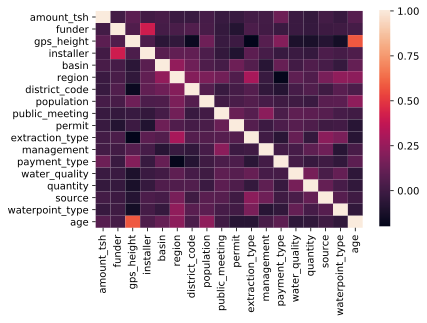

In [26]:
new_train_data.drop(features_to_delete, axis=1, inplace=True)
sns.heatmap(new_train_data.corr());

Так то лучше

LEts try KNN for age

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [28]:
X = new_train_data.loc[new_train_data['age'] != 0]
X_train, X_valid, y_train, y_valid = train_test_split(X.drop('age', axis=1), X['age'], test_size=0.3, random_state=42)
knn_params = {'knn__n_neighbors': np.arange(1, 11)}
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
knn = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

In [29]:
#knn.fit(X_train, y_train)

In [30]:
#knn.best_params_, knn.best_score_

In [31]:
#accuracy_score(y_valid, knn.predict(X_valid))

Теперь дерево

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
tree_params = {'tree__max_depth': np.arange(10, 30),
               'tree__max_features': np.arange(5, X_train.shape[1], 2),
               'tree__min_samples_leaf': np.arange(1, 6)}
tree_pipe = Pipeline([('tree', DecisionTreeClassifier(random_state=42))])
tree = GridSearchCV(tree_pipe, tree_params, cv=5, n_jobs=-1, verbose=True)

In [34]:
tree.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 211 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 711 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 1411 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 2311 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2993 out of 3000 | elapsed:  2.0min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tree__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29]), 'tree__max_features': array([ 5,  7,  9, 11, 13, 15]), 'tree__min_samples_leaf': array([1, 2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [35]:
tree.best_params_, tree.best_score_

({'tree__max_depth': 21, 'tree__max_features': 9, 'tree__min_samples_leaf': 1},
 0.879703134807813)

In [36]:
accuracy_score(y_valid, tree.predict(X_valid))

0.8832701585113715

Дерево получилось чуть лучше, будем использовать эту модель

In [37]:
Y = new_train_data.loc[new_train_data['age'] == 0].drop(['age'], axis=1)
Y['age'] = tree.predict(Y)
new_train_data.loc[new_train_data['age'] == 0] = Y

In [38]:
new_train_data['age'].value_counts()

1    33187
2    26213
Name: age, dtype: int64

В принципе, категорий как было примерно поровну, так и осталось, вроде, классифицировал неплохо

In [39]:
new_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 18 columns):
amount_tsh         59400 non-null float64
funder             59400 non-null int64
gps_height         59400 non-null int64
installer          59400 non-null int64
basin              59400 non-null int64
region             59400 non-null int64
district_code      59400 non-null int64
population         59400 non-null int64
public_meeting     59400 non-null int64
permit             59400 non-null int64
extraction_type    59400 non-null int64
management         59400 non-null int64
payment_type       59400 non-null int64
water_quality      59400 non-null int64
quantity           59400 non-null int64
source             59400 non-null int64
waterpoint_type    59400 non-null int64
age                59400 non-null int64
dtypes: float64(1), int64(17)
memory usage: 8.6 MB


Теперь все готово

In [47]:
test_data = pd.read_csv('702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')
test_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [48]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
id                       14850 non-null int64
amount_tsh               14850 non-null float64
date_recorded            14850 non-null object
funder                   13981 non-null object
gps_height               14850 non-null int64
installer                13973 non-null object
longitude                14850 non-null float64
latitude                 14850 non-null float64
wpt_name                 14850 non-null object
num_private              14850 non-null int64
basin                    14850 non-null object
subvillage               14751 non-null object
region                   14850 non-null object
region_code              14850 non-null int64
district_code            14850 non-null int64
lga                      14850 non-null object
ward                     14850 non-null object
population               14850 non-null int64
public_meeting           14029 non-null object
r

В тестовых данных иногда попадаются единичные значения `funder` и `installer`, которых не было в тренировочном датасете  
Пусть такие зачения будут будут в группе `unknown` 

In [49]:
test_data['funder'] = test_data['funder'].fillna('unknown')
test_data['installer'] = test_data['installer'].fillna('unknown')

test_data['funder'] = test_data['funder'].apply(
    lambda funder: funder if funder in funder_dict else 'unknown')
test_data['installer'] = test_data['installer'].apply(
    lambda installer: installer if installer in installer_dict else 'unknown')

test_data['funder'] = test_data['funder'].apply(
    lambda funder: funder if funder_dict[funder] > funder_mean else 'Other')
test_data['installer'] = test_data['installer'].apply(
    lambda installer: installer if installer_dict[installer] > installer_mean else 'Other')

In [50]:
test_data = prepare_data(test_data)
test_data.head()

,amount_tsh,funder,gps_height,installer,basin,region,region_code,district_code,lga,population,public_meeting,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,0.0,50,1996,96,4,19,21,3,86,321,1,7,1,3,3,3,6,3,1,1,1,1,4,4,5,5,2,3,3,1
51630,0.0,1,1569,1,2,6,2,2,2,300,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,1,1
17168,0.0,3,1567,3,4,14,13,2,11,500,1,1,3,3,3,3,1,1,1,1,1,1,2,2,5,5,2,3,3,1
45559,0.0,186,267,177,8,20,80,43,112,250,3,1,1,3,3,3,1,1,4,4,1,1,3,3,2,2,1,3,3,2
49871,500.0,2,1260,2,8,10,10,3,21,60,3,6,1,1,1,1,3,1,3,3,1,1,1,1,1,1,1,1,1,1


In [51]:
test_data.drop(features_to_delete, axis=1, inplace=True)

Построим модель

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(new_train_data, train_labels, test_size=0.3, random_state=42)

In [59]:
parameters = {'max_features': [5, 10, 15],
              'min_samples_leaf': [1, 3, 5], 
              'max_depth': [10, 20, 30],
              'n_estimators': [100, 200, 300]}
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rf = GridSearchCV(rfc, parameters, n_jobs=-1, cv=6, verbose=True)

In [60]:
rf.fit(X_train, y_train)

Fitting 6 folds for each of 81 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory le

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': [5, 10, 15], 'min_samples_leaf': [1, 3, 5], 'max_depth': [10, 20, 30], 'n_estimators': [100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [64]:
rf.best_params_, rf.best_score_

({'max_depth': 20,
  'max_features': 5,
  'min_samples_leaf': 3,
  'n_estimators': 300},
 0.7940115440115441)

In [71]:
pred = rf.predict(test_data)

In [73]:
pred = pd.DataFrame(index=test_data.index, data=pred, columns=['status_group'])

In [74]:
pred.head()

,status_group
id,
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional


In [75]:
pred.to_csv('pred.csv')

In [76]:
pred.status_group.value_counts()

functional                 9487
non functional             4979
functional needs repair     384
Name: status_group, dtype: int64

In [77]:
train_labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [79]:
# потюнить модель
# не удалть признаки
# извенить метрику